<a href="https://colab.research.google.com/github/mkatogui/Prueba_tecnica/blob/main/notebooks/parte_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de uso de cupón de descuento
Se hace uso del set de datos utilizado en la siguiente publicación:  
 * *Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry
MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The
Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393*

# Carga de librerías

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing, tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, roc_auc_score, roc_curve, auc
from sklearn.utils import check_random_state
from math import floor, sqrt

# Datos
Este trabajo tiene como objetivo realizar un modelo de clasificación sobre un set de datos público aplicando técnicas
de Machine Learning, que en este caso hará uso de una base de datos correspondiente a la
publicación: 'A bayesian framework for learning rule sets for interpretable classification.',
perteneciente a los autores Wang, Tong et al. Que fue publicado en The Journal of Machine
Learning Research. Estos datos fueron recopilados utilizando el sistema de Amazon Mechanical
Turk a través de encuestas, eliminando las entrevistas que estuvieron incompletas, permitieron
generar una muestra de tamaño n=12684. El trabajo se enfoca en realizar una predicción sobre el
comportamiento del usuario, que podrá optar por aceptar un cupón de descuento, siendo la
respuesta del cliente: “ahora” o “después, antes que espire el cupón” en la variable “Y = 1”, y “no,
no quiero el cupón” con “Y = 0”. Los cupones que se ofrecen pueden ser canjeados 5 tipos de
lugares, siendo: Bar, Comida para Llevar de restaurante, cafeterías, restaurante barato (<20 USD
por persona), restaurante caro (20 a 50 USD por persona). Al comenzar la entrevista se pide
información demográfica y de preferencias, para luego continuar con 20 escenarios diferentes de
conducción con información de contexto, por ejemplo, misma dirección o contraria al
restaurante/bar, y del tipo de cupón, preguntándole al entrevistado si aceptaría o rechazaría el
uso de cupón.


In [11]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/publico/in-vehicle-coupon-recommendation.csv",sep=";")

# Crear la tabla de contingencia
tabla = pd.crosstab(df['coupon'], df['Y'])

# Convertir a porcentajes
tabla_porcentaje = (tabla / tabla.sum().sum()) * 100
tabla_porcentaje

# Crear la tabla de contingencia
tabla_2 = pd.crosstab(df['age'], df['Y'])

# Convertir a porcentajes
tabla_2_porcentaje = (tabla_2 / tabla_2.sum().sum()) * 100

# Descripción general
La base de datos tiene un total de 25 atributos que toman distintos valores, algunos son
categóricos y otros numéricos. Con respecto a la variable edad, se utilizó una metodología similar
al artículo de la base de datos, donde se determinó distintas variables dependiendo del rango
etario, menores de 21 y por encima de 50 años, luego se tomó a los valores de 21 y 26 años que se
generó una variable que los incluye “entre 20 y 30 años”, lo mismo se realizó para las edades 31 y
36 años, que se incluyó “entre 30 y 40 años”, continuando con las edades de 41 y 46, que se los
consideró “entre 40 y 50 años”. Por simplicidad, no se continuó realizando transformaciones
utilizadas en la publicación de los datos, ya que el objetivo de los autores era demostrar la
eficiencia de un método de estimación bayesiana.

La siguiente tabla nos indica el tipo de cupón y las cantidades ofrecidas en la
muestra, además de ello, se muestran las proporciones de aceptación que tuvo cada tipo de cupón.
Podemos notar que los cupones “Carry out & Take away” tuvieron la mayor proporción de éxito,
con un 74% de aceptación, seguido de “Restaurant(<20)”, que tuvo una aceptación del 71%,
mientras que “Coffee House”, “Restaurant(20-50)” y “Bar”, estos niveles de aceptación estuvieron
por debajo del 50%, inclusive. A modo general, podemos apreciar que el promedio de aceptación
total fue del 57%.

Las tablas gráficas difieren de los números de la tabla de python ya que fueron procesados en un archivo excel haciendo un ratio del nivel aceptado sobre el total de esa categoría.


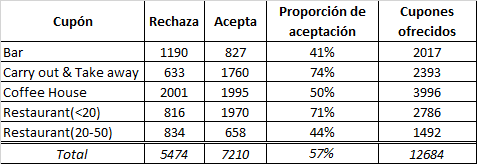

In [21]:
pd.merge(tabla_porcentaje, tabla, how='inner', on='coupon')

Y,0_x,1_x,0_y,1_y
coupon,,,,
Bar,9.381898,6.520025,1190,827
Carry_out_and_Take_away,4.990539,13.875749,633,1760
Coffee_House,15.775781,15.728477,2001,1995
Restaurant_20_50,6.575213,5.187638,834,658
Restaurantless_20,6.433302,15.531378,816,1970


Continuando con el análisis general, en la siguiente tabla se muestra el rango de edades y la
cantidad de aceptación que tuvo cada grupo etario, donde es posible apreciar que la aceptación de
los cupones se distribuye alrededor de 57% (+-6%). Siendo las personas entre 20 y 30 años el
grupo que mayor cantidad de observaciones tuvo en la encuesta.

Las tablas gráficas difieren de los números de la tabla de python ya que fueron procesados en un archivo excel haciendo un ratio del nivel aceptado sobre el total de esa categoría.

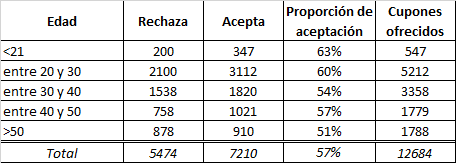


In [17]:
pd.merge(tabla_2_porcentaje, tabla_2, how='inner', on='age')

Y,0_x,1_x,0_y,1_y
age,,,,
21,8.404289,12.511826,1066,1587
26,8.152003,12.023021,1034,1525
31,7.292652,8.782718,925,1114
36,4.832860,5.566067,613,706
41,3.681804,4.935352,467,626
46,2.294229,3.114160,291,395
50plus,6.922107,7.174393,878,910
below21,1.576790,2.735730,200,347


# Data Engineering
Como se ha mencionado anteriormente, para transformar la variable edad se utilizó una metodología similar al artículo de la base de datos, donde se determinó distintas variables dependiendo del rango etario, menores de 21 y por encima de 50 años, luego se tomó a los valores de 21 y 26 años que se generó una variable que los incluye “entre 20 y 30 años”, lo mismo se realizó para las edades 31 y 36 años, que se incluyó “entre 30 y 40 años”, continuando con las edades de 41 y 46, que se los consideró “entre 40 y 50 años”.

In [22]:
# Semilla
seed = 12345
# establecemos semilla
check_random_state(seed)

# Create binary variables based on 'age' and drop 'age' column
df['over50'] = (df['age'] == '50plus').astype(int)
df['below21'] = (df['age'] == 'below21').astype(int)
df['b21_26'] = df['age'].isin(['21', '26']).astype(int)
df['in30s'] = df['age'].isin(['31', '36']).astype(int)
df['in40s'] = df['age'].isin(['41', '46']).astype(int)
df.drop('age', axis=1, inplace=True)

# Convert columns to categorical
factorize_columns = df.columns[[0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]]
df_encoded = pd.get_dummies(df, columns=factorize_columns)

# Define target variable
Y = df_encoded.pop('Y')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_encoded, Y, test_size=0.3, random_state=seed)


# Modelo benchmark
El modelo que será de comparación a otros modelos será el modelo logístico, un modelo paramétrico utilizado en las mayorías de los proyectos de clasificación como el modelo mas sencillo.

Este modelo arroja un ratio de error sobre el modelo del:
* Entrenamiento - tasa de error: *0.301307*
* Validación - tasa de error: *0.321335*


También es posible observar los parámetros del modelo logístico y así realizar una interpretación de ls principales variables que impactan a la hora de realizar la clasificación, siendo algunos de estos:

* Variable: temperature, Score: -0.00150
* Variable: has_children, Score: 0.08823
* Variable: toCoupon_GEQ5min, Score: 0.05765
* Variable: toCoupon_GEQ15min, Score: -0.05276
* Variable: toCoupon_GEQ25min, Score: 0.21582
* Variable: direction_same, Score: 0.26380
* Variable: direction_opp, Score: -0.20615
* Variable: over50, Score: -0.09047
* Variable: below21, Score: 0.03182
* Variable: b21_26, Score: 0.08183
* Variable: in30s, Score: -0.08832
* Variable: in40s, Score: 0.12278
* Variable: destination_Home, Score: -0.27760
* Variable: destination_No_Urgent_Place, Score: 0.49552
* Variable: destination_Work, Score: -0.16027
* Variable: passanger_Alone, Score: 0.00406
* Variable: passanger_Friend_s, Score: 0.24717
* Variable: passanger_Kid_s, Score: -0.36912
* Variable: passanger_Partner, Score: 0.17554
* Variable: weather_Rainy, Score: -0.00175
* Variable: weather_Snowy, Score: -0.34410
* Variable: weather_Sunny, Score: 0.40350
* Variable: time_10AM, Score: 0.08121
* Variable: time_10PM, Score: -0.16463
* Variable: time_2PM, Score: -0.00480
* Variable: time_6PM, Score: 0.30614
* Variable: time_7AM, Score: -0.16027

Una lectura rápida y simplista podría decirse que si la persona que recibe el cupón a las 6 PM, dirigiéndose a un lugar que no es de urgencia, donde la edad de la persona está en sus 40 años, disponiendo de un tiempo de 25 minutos, tiene hijos, el acompañante es un amigo, no hace tanto calor siendo un día soleado, se incrementa la probabilidad de que acepte el cupón. A continuación se mencionan las variables utilizadas para redactar el texto:
* Variable: time_6PM, Score: 0.30614
* Variable: destination_No_Urgent_Place, Score: 0.49552
* Variable: in40s, Score: 0.12278
* Variable: toCoupon_GEQ25min, Score: 0.21582
* Variable: has_children, Score: 0.08823
* Variable: passanger_Friend_s, Score: 0.24717
* Variable: temperature, Score: -0.00150
* Variable: weather_Sunny, Score: 0.40350

In [34]:
# Fit a logistic regression model
model_log = LogisticRegression(solver="liblinear")
model_log.fit(X_train, y_train)

# Make predictions
predictions_train = model_log.predict(X_train)
predictions_val = model_log.predict(X_val)

# Print classification report
print(classification_report(y_train, predictions_train))
print(classification_report(y_val, predictions_val))

# confusion matrix del modelo logístico
conf_logistico_train = confusion_matrix(y_train, predictions_train)
conf_logistico_val = confusion_matrix(y_val, predictions_val)
# Print confusion matrix
print(conf_logistico_train)
print(conf_logistico_val)

# Error Rate
error_rate_log_train = 1 - np.trace(conf_logistico_train) / len(y_train)
error_rate_log_val = 1 - np.trace(conf_logistico_val) / len(y_val)
print(f'Error Rate sobre entrenamiento: {error_rate_log_train:.7f}')
print(f'Error Rate sobre validación: {error_rate_log_val:.7f}')

# Get feature importance
importance = model_log.coef_[0]

# Get feature names
feature_names = df_encoded.columns.tolist()

# print the feature importances along with feature names
for i,v in enumerate(importance):
    print('Feature/Variable: %s, Score: %.5f' % (feature_names[i],v))

              precision    recall  f1-score   support

           0       0.67      0.59      0.63      3814
           1       0.72      0.78      0.75      5064

    accuracy                           0.70      8878
   macro avg       0.69      0.69      0.69      8878
weighted avg       0.70      0.70      0.70      8878

              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1660
           1       0.69      0.77      0.73      2146

    accuracy                           0.68      3806
   macro avg       0.67      0.66      0.67      3806
weighted avg       0.68      0.68      0.67      3806

[[2255 1559]
 [1116 3948]]
[[ 924  736]
 [ 487 1659]]
Error Rate sobre entrenamiento: 0.3013066
Error Rate sobre validación: 0.3213347
Feature/Variable: temperature, Score: -0.00150
Feature/Variable: has_children, Score: 0.08823
Feature/Variable: toCoupon_GEQ5min, Score: 0.05765
Feature/Variable: toCoupon_GEQ15min, Score: -0.05276
Feature/Varia

# Treebag

"Treebag" es un término que se usa en el campo del aprendizaje automático y se refiere a una técnica conocida como "Bagging de Árboles de Decisión".

El Bagging, que es una abreviatura de Bootstrap Aggregating, es una técnica de ensamble que busca reducir la varianza de un modelo de aprendizaje automático. Esta técnica implica entrenar varios modelos (en este caso, árboles de decisión) en diferentes subconjuntos de los datos de entrenamiento (seleccionados aleatoriamente con reemplazo), y luego combinar sus predicciones.

## Una vez encontrado el alpha que minimiza el error, las nuevas tasas de errores son:
* Entrenamiento - tasa de error: *0.3058121*
Con un área debajo de la curva del *0.735*,
* Validación - tasa de error: *0.329480*
El ROC pasa a ser del *0.7155*

A continuación presentamos el código generado para realizar el entrenamiento y validación del modelo.

Cross-validation scores: [0.5        0.62096277 0.54318362 0.63407051 0.63699678]


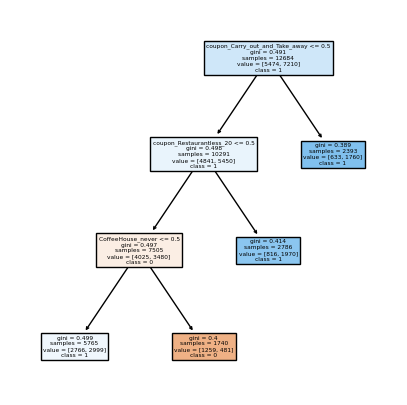

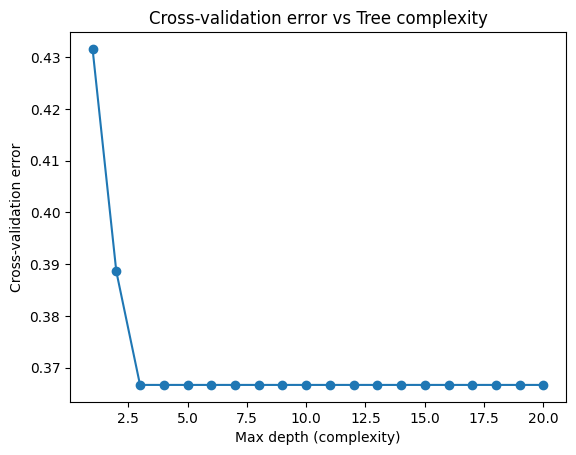

Feature: temperature, Score: 0.00000
Feature: has_children, Score: 0.00000
Feature: toCoupon_GEQ5min, Score: 0.00000
Feature: toCoupon_GEQ15min, Score: 0.00000
Feature: toCoupon_GEQ25min, Score: 0.00000
Feature: direction_same, Score: 0.00000
Feature: direction_opp, Score: 0.00000
Feature: over50, Score: 0.00000
Feature: below21, Score: 0.00000
Feature: b21_26, Score: 0.00000
Feature: in30s, Score: 0.00000
Feature: in40s, Score: 0.00000
Feature: destination_Home, Score: 0.00000
Feature: destination_No_Urgent_Place, Score: 0.00000
Feature: destination_Work, Score: 0.00000
Feature: passanger_Alone, Score: 0.00000
Feature: passanger_Friend_s, Score: 0.00000
Feature: passanger_Kid_s, Score: 0.00000
Feature: passanger_Partner, Score: 0.00000
Feature: weather_Rainy, Score: 0.00000
Feature: weather_Snowy, Score: 0.00000
Feature: weather_Sunny, Score: 0.00000
Feature: time_10AM, Score: 0.00000
Feature: time_10PM, Score: 0.00000
Feature: time_2PM, Score: 0.00000
Feature: time_6PM, Score: 0.0000

In [37]:
## Tree bag
# Set random seed for reproducibility
np.random.seed(seed)

#Generación de
X = df_encoded
y = Y

# Create a label encoder
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)

# Create the decision tree classifier
clf = DecisionTreeClassifier(criterion="gini",
                             min_samples_split=500,
                             ccp_alpha=0.008,
                             max_depth=20,
                             random_state=seed)

# Perform 5-fold cross validation
scores = cross_val_score(clf, X, y_encoded, cv=5, scoring=make_scorer(roc_auc_score))

print("Cross-validation scores:", scores)

# Fit the model to the data
clf = clf.fit(X, y_encoded)

# Get feature names
feature_names = list(X.columns)

# Get class names (as strings)
class_names = list(le.classes_.astype(str))

# Plot the decision tree with feature names and class names
fig, ax = plt.subplots(figsize=(5, 5))
tree.plot_tree(clf,
               feature_names=feature_names,
               class_names=class_names,
               filled=True,
               ax=ax)
plt.show()


# Range of values to try for max_depth
max_depth_values = range(1, 21)

# List to store average cross-validation score for each value of max_depth
cv_scores = []

# Perform 5-fold cross-validation for each value of max_depth and record the scores
for max_depth in max_depth_values:
    clf.max_depth = max_depth
    scores = cross_val_score(clf, X, y, cv=5)
    cv_scores.append(scores.mean())

# Plot cross-validation error vs max_depth
plt.figure()
plt.plot(max_depth_values, [1 - score for score in cv_scores], marker='o')
plt.xlabel('Max depth (complexity)')
plt.ylabel('Cross-validation error')
plt.title('Cross-validation error vs Tree complexity')
plt.show()

# Get feature names
feature_names = df_encoded.columns.tolist()

# print the feature importances along with feature names
for i,v in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (feature_names[i],v))

# Compute the cost-complexity pruning path
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

## Selección de hiperparámetros

El hiperparámetro que optimiza el modelo es:
* Optimal CCP Alpha: 0.0015805484348982851


Optimal CCP Alpha: 0.0015805484348982851


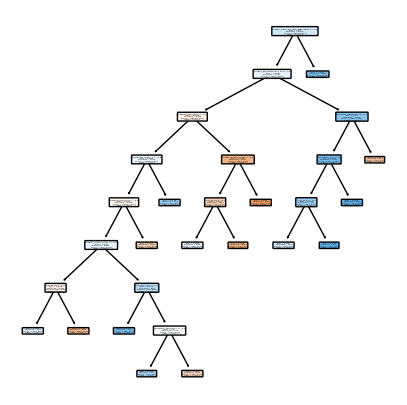

In [38]:
# Find the ccp_alpha that minimizes the cross-validation error
clf_scores = []
for ccp_alpha in ccp_alphas:
    clf.ccp_alpha = ccp_alpha
    scores = cross_val_score(clf, X, y, cv=5)
    clf_scores.append(scores.mean())

# Get the optimal ccp_alpha
optimal_ccp_alpha = ccp_alphas[np.argmax(clf_scores)]

print("Optimal CCP Alpha:", optimal_ccp_alpha)


# Prune the decision tree
clf.ccp_alpha = optimal_ccp_alpha
clf_pruned = clf.fit(X_train, y_train)

# Plot the pruned tree
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust size as per your need
tree.plot_tree(clf_pruned,
          filled=True,
          rounded=True,
          class_names=['Class 1', 'Class 2'],  # Replace with your actual class names
          feature_names=X.columns,  # Replace X with your actual data
          ax=ax)
plt.show()

## Resultados del modelo optimizado


* Entrenamiento - tasa de error: *0.3058121*
Con un área debajo de la curva del *0.735*,
* Validación - tasa de error: *0.329480*
El ROC pasa a ser del *0.7155*


[1 1 1]
[[2033 1781]
 [ 934 4130]]
Error Rate: 0.3058121


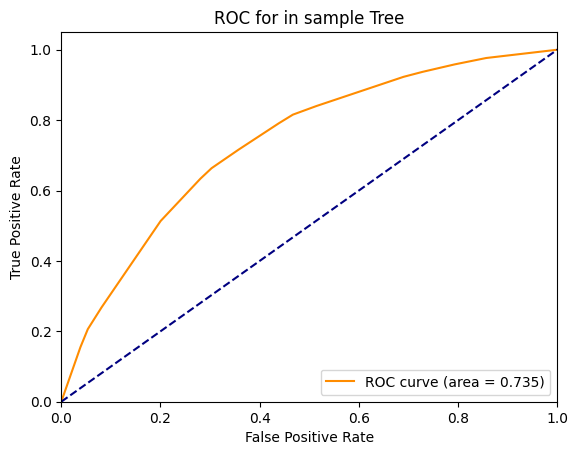

Area under the ROC curve out of sample: 0.715581


In [39]:
# Predictions (in sample) with the pruned tree
pred_acp = clf_pruned.predict(X_train)

# Display first 3 predictions
print(pred_acp[:3])

# Confusion Matrix (training data)
conf_mat = confusion_matrix(y_train, pred_acp)
print(conf_mat)

# Error Rate
error_rate = 1 - np.trace(conf_mat) / len(y_train)
print(f'Error Rate: {error_rate:.7f}')
# Error Rate = 0.3140347

# ROC Curve
pred_acp_prob = clf_pruned.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_train, pred_acp_prob)
auc = roc_auc_score(y_train, pred_acp_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for in sample Tree')
plt.legend(loc="lower right")
plt.show()

roc_auc = roc_auc_score(y_val, clf_pruned.predict_proba(X_val)[:, 1])

print("Area under the ROC curve out of sample: %f" % roc_auc)

## Importancia de los features
Con respecto a las variables que mas impacto tienen en el modelo, se ordenan de mayor a menor visualizando los 20 principales.
Lográndose interpretar que la persona que elige hacer uso del cupón cuando el restaurant tiene un precio menor a 20 dólares, la persona nunca va a una casa de café, y el cupón le permite realizar la compra y llevarse a su casa. Esta lectura fue realizada haciendo uso de las siguientes variables:
* coupon_Restaurantless_20                      0.232761
* CoffeeHouse_never                             0.162701
* coupon_Carry_out_and_Take_away                0.148208

In [40]:
# Display feature importance
feature_importance = pd.DataFrame(clf_pruned.feature_importances_, index=X_train.columns, columns=['importance'])
print(feature_importance.sort_values('importance', ascending=False).head(20))

                                            importance
coupon_Restaurantless_20                      0.232761
CoffeeHouse_never                             0.162701
coupon_Carry_out_and_Take_away                0.148208
toCoupon_GEQ25min                             0.097959
Bar_never                                     0.063568
passanger_Friend_s                            0.063229
coupon_Coffee_House                           0.062184
CoffeeHouse_less1                             0.043610
expiration_2h                                 0.036828
expiration_1d                                 0.035812
time_6PM                                      0.034021
toCoupon_GEQ15min                             0.019120
income_87500_99999                            0.000000
income_62500_74999                            0.000000
income_75000_87499                            0.000000
car_Car_that_is_too_old_to_install_Onstar_    0.000000
income_Less_than_12500                        0.000000
car_Mazda5

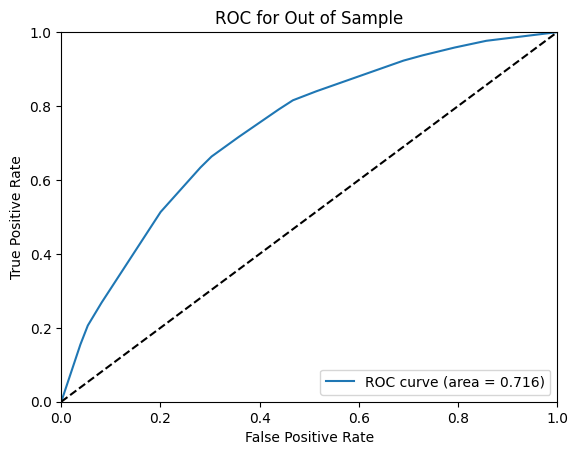

Train - Error rate : 0.305812
Val - Error rate : 0.329480


In [41]:
# Plot ROC curve
plt.clf()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Out of Sample')
plt.legend(loc="lower right")
plt.show()

# Predict classes
mod2_pred_train = clf_pruned.predict(X_train)
mod2_pred_val = clf_pruned.predict(X_val)

# Create confusion matrix
conf_mat_train = confusion_matrix(y_train, mod2_pred_train)
conf_mat_val = confusion_matrix(y_val, mod2_pred_val)

# Calculate error rate
error_rate_train = 1 - np.trace(conf_mat_train) / len(y_train)
error_rate_val = 1 - np.trace(conf_mat_val) / len(y_val)
print("Train - Error rate : %f" % error_rate_train)
print("Val - Error rate : %f" % error_rate_val)

# Gradient Boosting Machine
El modelo utilizado en esta sección corresponde al Gradient Boosting Machine (GBM), el cual es un algoritmo de aprendizaje supervisado que se utiliza para problemas de clasificación y regresión. Es una técnica potente y muy efectiva que construye un modelo predictivo en forma de conjunto de modelos de predicción débiles, generalmente árboles de decisión.

Sin realizar selección de hiperparámetros, el modelo nos está arrojando las siguientes tasas de errores:
* Conjunto de entrenamiento *0.417324*
* Conjunto de validación *0.427220*

Tasas de error post selección de hiperparámetros:
* Entrenamiento - tasa de error 0.03424
* Validación - tasa de error: 0.25880

Para simplicar el análisis, no se realizará gráficos ROC y otro tipo de análisis (tampoco se analizará la matriz de confusión, que sí se muestra en esta sección como resultado).

In [42]:
# Set seed for reproducibility
np.random.seed(seed)

# Define the model
clf_gbm = GradientBoostingClassifier(loss='log_loss',
                                     learning_rate=0.01,
                                     n_estimators=100,
                                     subsample=0.5,
                                     criterion='friedman_mse',
                                     min_samples_split=500,
                                     min_samples_leaf=3,
                                     min_weight_fraction_leaf=0.,
                                     max_depth=4,
                                     verbose=True,
                                     random_state=seed)

# Fit the model
clf_gbm.fit(X_train, y_train, sample_weight=(1 + y_train) * 2)

# Sobre conjunto entrenamiento
# Generate predictions
pred_gmb_train = clf_gbm.predict_proba(X_train)[:, 1]

# Transform predictions based on threshold
pred_gmb_train = np.where(pred_gmb_train > 0.5, 1, 0)


# Sobre el conjunto de validación
# Predict probabilities
pred_gmb = clf_gbm.predict_proba(X_val)[:, 1]

# Transform predictions based on threshold
pred_gmb = np.where(pred_gmb > 0.5, 1, 0)

# Calculate error
error_train = 1 - np.sum(np.diag(pd.crosstab(y_train, pred_gmb_train))) / len(y_train)
error_val = 1 - np.sum(np.diag(pd.crosstab(y_val, pred_gmb))) / len(y_val)

print("Train - Error rate:  %f" % error_train)
print("Val - Error rate:  %f" % error_val)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1787           0.0023            1.60s
         2           1.1737           0.0024            1.54s
         3           1.1547           0.0022            1.58s
         4           1.1579           0.0026            1.56s
         5           1.1623           0.0021            1.54s
         6           1.1621           0.0020            1.52s
         7           1.1590           0.0022            1.50s
         8           1.1578           0.0020            1.49s
         9           1.1567           0.0020            1.47s
        10           1.1478           0.0020            1.47s
        20           1.1444           0.0018            1.31s
        30           1.1191           0.0011            1.46s
        40           1.0924           0.0011            1.72s
        50           1.0893           0.0012            1.53s
        60           1.0750           0.0010            1.27s
       

## Selección de hiperparámetros
Se realiza una grilla y luego se utiliza una búsqueda aleatoria de los hiperparámetros, dando como resultado:
* subsample: 0.75
* n_estimators: 360
* max_depth: 5
* learning_rate: 0.5

In [43]:
# Hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [1, 3, 5, 10],
    'subsample': [0.25, 0.5, 0.75],
    'n_estimators': range(10, 500, 50)
}

# Use AUC as scoring metric
auc_scoring = make_scorer(roc_auc_score)

# Perform grid search
grid_clf = RandomizedSearchCV(clf_gbm, param_distributions=param_grid, scoring=auc_scoring,verbose=2, cv=5, n_jobs=-1,n_iter=20)

grid_clf.fit(X_train, y_train)

# Get best parameters
best_params_GBM = grid_clf.best_params_
print(best_params_GBM)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2460           0.1137           10.31s
         2           1.1825           0.0520            9.88s
         3           1.1521           0.0223            9.86s
         4           1.1307           0.0079            9.68s
         5           1.1193           0.0107            9.65s
         6           1.1074           0.0020            9.68s
         7           1.1009           0.0038            9.68s
         8           1.0881           0.0027            9.87s
         9           1.0846           0.0033            9.84s
        10           1.0634           0.0017            9.75s
        20           1.0169          -0.0016            9.46s
        30           0.9629          -0.0042            9.09s
        40           0.9300          -0.0032            8.79s
        50           0.9127          -0.0042            8.52s
       

## Resultados del modelo optmizado
A simple vista podemos ver que el modelo ha generado un overfitting sobre el conjunto de entrenamiento, llevando a una tasa de error muy baja, mientras que cuando le pasamos el conjunto de validación, esta tasa se incrementa fuertemente. Los siguientes números corresponden a las tasas de error:
* Entrenamiento - tasa de error  *0.03424*
* Validación - tasa de error:  *0.25880*

In [44]:
#Validation
gbm_model = GradientBoostingClassifier(**best_params_GBM)

# Train the model with the best parameters
gbm_model.fit(X_train, y_train)

# Predict on the validation data
pred_gmb_train = gbm_model.predict_proba(X_train)[:, 1]

# Transform predictions based on threshold
pred_gmb_train = np.where(pred_gmb_train > 0.5, 1, 0)

# Predict on the validation data
pred_gmb_val = gbm_model.predict_proba(X_val)[:, 1]

# Transform predictions based on threshold
pred_gmb_val = np.where(pred_gmb_val > 0.5, 1, 0)

# Print the confusion matrix
conf_matrix_train = confusion_matrix(y_train, pred_gmb_train)
print(conf_matrix_train)

# Print the confusion matrix
conf_matrix_val = confusion_matrix(y_val, pred_gmb_val)
print(conf_matrix_val)

# Calculate the error rate
error_rate_GBM_train = 1 - np.sum(np.diag(conf_matrix_train)) / len(y_train)
error_rate_GBM_val = 1 - np.sum(np.diag(conf_matrix_val)) / len(y_val)
print("Train - Error Rate GBM: ", error_rate_GBM_train)
print("Val - Error Rate GBM: ", error_rate_GBM_val)

[[3789   25]
 [  11 5053]]
[[1137  523]
 [ 418 1728]]
Train - Error Rate GBM:  0.004054967334985338
Val - Error Rate GBM:  0.24724119810825018


## Importancia de los features
En esta sección no se realizará interpretación de los resultados

In [45]:
# Display feature importance
feature_importance = pd.DataFrame(gbm_model.feature_importances_, index=X_train.columns, columns=['importance'])
print(feature_importance.sort_values('importance', ascending=False).head(20))

                                importance
coupon_Restaurantless_20          0.038165
coupon_Carry_out_and_Take_away    0.037657
coupon_Coffee_House               0.033872
coupon_Bar                        0.030333
CoffeeHouse_never                 0.029572
toCoupon_GEQ25min                 0.023892
temperature                       0.021709
expiration_1d                     0.021683
Bar_never                         0.021355
coupon_Restaurant_20_50           0.018587
time_10AM                         0.018498
time_6PM                          0.018232
toCoupon_GEQ15min                 0.017784
passanger_Friend_s                0.017143
destination_No_Urgent_Place       0.016735
CoffeeHouse_less1                 0.015983
expiration_2h                     0.014509
passanger_Kid_s                   0.013524
weather_Sunny                     0.013113
in30s                             0.013071


# XGBoost
Similar al modelo anterior (GBM), el presente se denomina XGBoost, o Extreme Gradient Boosting, es un algoritmo de aprendizaje supervisado basado en árboles. Es una implementación de la técnica de Gradient Boosting que está diseñada para ser altamente eficiente, flexible y portátil.

En este bloque de código se realizará el entrenamiento y selección de los hiperparámetros, para simplicar solamente.

Las tasas de error obtenidas son sin optimizar los hiperparámetros:
* Train - Error rate :  *0.570399*
* Val - Error rate :  *0.563847*

Una vez optimizado los hiperparámetros, las nuevas tasas de errores son:
* Train - Error Rate xgboost:  *0.007096*
* Val - Error Rate xgboost:  *0.258802*

A simple vista podemos notar que la tasa de error mejora sobre el conjunto de entrenamiento y también mejorar en el conjunto de validación de manera significativa.

Se recomienda **Revisar el código para buscar errores y disminuir el overfitting en la slección de hiperparámetros**


In [46]:
### XGBOOST ###
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

# Set seed for reproducibility
np.random.seed(seed)

# Define the model
clf_xgb = XGBClassifier(objective='binary:logistic',
                        learning_rate=0.01,
                        n_estimators=10,
                        subsample=0.5,
                        max_depth=2,
                        verbosity=1,
                        random_state=seed)

# Fit the model
clf_xgb.fit(X_train, y_train, sample_weight=(1 + y_train) * 2)

# Predict probabilities
pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]
pred_xgb_val = clf_xgb.predict_proba(X_val)[:, 1]

# Transform predictions based on threshold
pred_xgb_train = np.where(pred_xgb_train > 0.6, 1, 0)
pred_xgb_val = np.where(pred_xgb_val > 0.6, 1, 0)

# Calculate error
error_train = 1 - np.sum(np.diag(pd.crosstab(y_train, pred_xgb_train))) / len(y_train)
error_val = 1 - np.sum(np.diag(pd.crosstab(y_val, pred_xgb_val))) / len(y_val)
print("Train - Error rate : ",error_train)
print("Val - Error rate : ",error_val)

Train - Error rate :  0.5703987384546069
Val - Error rate :  0.5638465580662113


### Selección de hiperparámetros
A continuación se buscará los hiperparámetros mediante una búsqueda aleatoria, para disminuir tiempo de cómputo.

In [47]:
# Hyperparameter tuning
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5],
              'max_depth': [1, 2, 3, 5, 7, 10, 15],
              'subsample': [0.25, 0.5, 0.75],
              'n_estimators': range(10, 100, 10)}

# Use AUC as scoring metric
auc_scoring = make_scorer(roc_auc_score)

# Perform grid search
grid_clf = RandomizedSearchCV(clf_xgb, param_grid, scoring=auc_scoring,verbose=2, cv=5, n_jobs=-1,n_iter=20)
grid_clf.fit(X_train, y_train)

# Get best parameters
best_params_XGBOOST = grid_clf.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


#### Hiperparámetros optimizados
A continuación se muestra la selección de los hiperparámetros y se realiza el entrenamiento del nuevo modelo

Los hiperparámetros seleccionado son:
* subsample: 0.75
* n_estimators: 90
* max_depth: 15
* learning_rate': 0.1

In [48]:
print(best_params_XGBOOST)

#Validation
xgboost_model = XGBClassifier(**best_params_XGBOOST)

# Train the model with the best parameters
xgboost_model.fit(X_train, y_train)

{'subsample': 0.75, 'n_estimators': 90, 'max_depth': 15, 'learning_rate': 0.1}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=90, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Validation XGBoost

In [49]:
# Predict
pred_xgboost_train = xgboost_model.predict_proba(X_train)[:, 1]
pred_xgboost_val = xgboost_model.predict_proba(X_val)[:, 1]

# Transform predictions based on threshold
pred_xgboost_train = np.where(pred_xgboost_train > 0.6, 1, 0)
pred_xgboost_val = np.where(pred_xgboost_val > 0.6, 1, 0)

# Print the confusion matrix
conf_matrix_train = confusion_matrix(y_train, pred_xgboost_train)
conf_matrix_val = confusion_matrix(y_val, pred_xgboost_val)
print(conf_matrix_train)
print(conf_matrix_val)

# Calculate the error rate
error_rate_xgboost_train = 1 - np.sum(np.diag(conf_matrix_train)) / len(y_train)
error_rate_xgboost_val = 1 - np.sum(np.diag(conf_matrix_val)) / len(y_val)
print("Train - Error Rate xgboost: ", error_rate_xgboost_train)
print("Val - Error Rate xgboost: ", error_rate_xgboost_val)

[[3811    3]
 [  60 5004]]
[[1200  460]
 [ 454 1692]]
Train - Error Rate xgboost:  0.007096192836224424
Val - Error Rate xgboost:  0.24014713610089333


## Importancia de los features

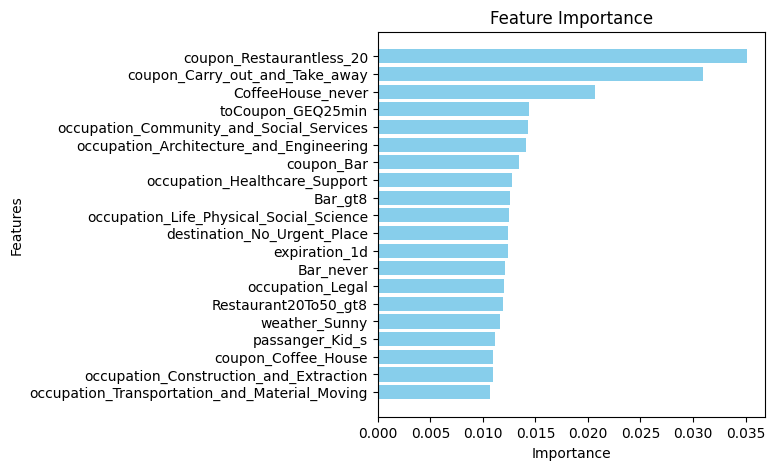

In [50]:
# Display feature importance
feature_importance = pd.DataFrame(xgboost_model.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

# Plotting
plt.figure(figsize=(5, 5)) # Change figure size based on number of features
plt.barh(feature_importance.index, feature_importance['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis() # To display the highest value at the top
plt.show()

# Random Forest

El "Random Forest" es un algoritmo de aprendizaje automático que crea una colección de árboles de decisión y los combina para obtener un resultado más preciso y estable. Selecciona aleatoriamente características para cada árbol y divide los nodos hasta alcanzar un número especificado. Las predicciones se basan en la mayoría de votos o en la media para problemas de clasificación y regresión respectivamente. Es potente, versátil y eficaz para evitar el sobreajuste.

El siguiente bloque de código se realiza un entrenamiento del modelo y luego una validación de ese modelo, lo que podemos observar en sus tasas de error es que se mantiene estable en ambos conjuntos de datos (entrenamiento y validación):
* Entrenamiento - tasa de error del modelo RF:  *0.371367*
* Validación - tasa de error del modelo RF:  *0.379664*

###Resultado post selección de hiperparámetros

Luego de realizada la selección de los hiperparémtros que opimizan el modelo, la nueva **tasa de error**:
* Entrenamiento - tasa de error:  *0.295112*
* Validación - tasa de error:  *0.320021*


Los hiperparámetros seleccionado son:
* max_leaf_nodes: 30
* min_samples_leaf: 100
* n_estimators: 500

In [56]:
# Create the random forest classifier
rf_model = RandomForestClassifier(
    n_estimators=700,
    max_features=floor(sqrt(X_train.shape[1])),
    max_leaf_nodes=10,
    min_samples_leaf=500,
    bootstrap=True,
    oob_score=True,
    random_state=seed
)

# Fit the model
rf_model.fit(X_train, y_train)

# Display out-of-bag predictions for each observation
oob_predictions = rf_model.oob_decision_function_
print(oob_predictions[:10])

# Display predicted categories
predicted_categories_train = rf_model.predict(X_train)
predicted_categories_val = rf_model.predict(X_val)
print(predicted_categories_val[:10])

# Display number of times each observation was out-of-bag (OOB score)
oob_score = rf_model.oob_score_

# Display confusion matrix
rf_confusion_mat_train = confusion_matrix(y_true=y_train, y_pred=predicted_categories_train)
rf_confusion_mat_val = confusion_matrix(y_true=y_val, y_pred=predicted_categories_val)


# Calculate the error rate
error_rate_rf_train = 1 - np.sum(np.diag(rf_confusion_mat_train)) / len(y_train)
error_rate_rf_val = 1 - np.sum(np.diag(rf_confusion_mat_val)) / len(y_val)
print("Train - Error Rate RF: ", error_rate_rf_train)
print("Val - Error Rate RF: ", error_rate_rf_val)

# Predict on validation data
predicted_probabilities_before_tuning = rf_model.predict_proba(X_val)[:, 1]

[[0.47194515 0.52805485]
 [0.38936422 0.61063578]
 [0.42384569 0.57615431]
 [0.32306157 0.67693843]
 [0.48908938 0.51091062]
 [0.49273379 0.50726621]
 [0.37759758 0.62240242]
 [0.43044006 0.56955994]
 [0.47852684 0.52147316]
 [0.44508229 0.55491771]]
[1 1 1 1 1 0 1 1 1 1]
Train - Error Rate RF:  0.3713674250957423
Val - Error Rate RF:  0.3796636889122438


Se vuelve a cargar la librería porque generaba inconvenientes para correr el script
* from sklearn.metrics import roc_curve, auc


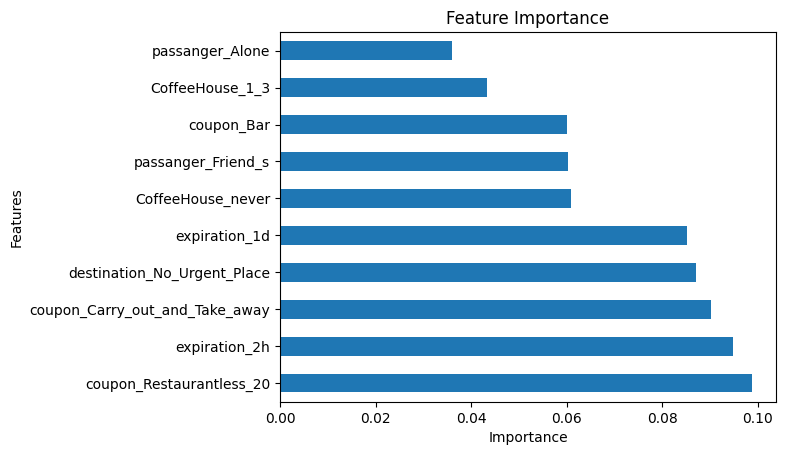

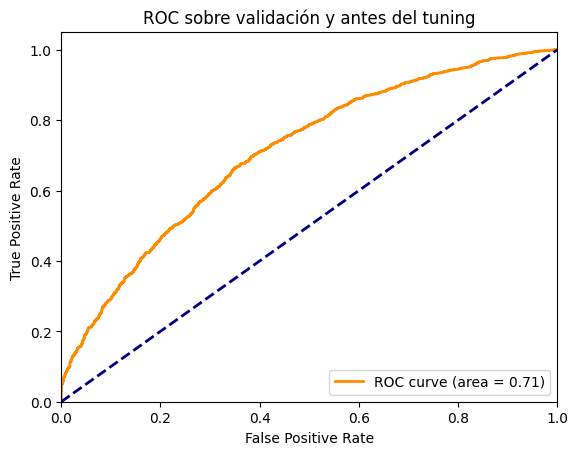

In [58]:
from sklearn.metrics import roc_curve, auc

# Plot feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()
predicted_labels_before_tuning = np.where(predicted_probabilities_before_tuning>0.5,1,0)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_val, predicted_probabilities_before_tuning)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC sobre validación y antes del tuning')
plt.legend(loc="lower right")
plt.show()

## Tuning de hiperparámetros

A continuación se realizará el hiperparameter tuning del modelo de RF. Para ello se buscará explorar de manera exhaustiva una grilla compuesta por:

*    n_estimators: [10, 100,500,1000],
*    max_leaf_nodes: [5,10, 20, 30, 50],
*    min_samples_leaf: [100,150, 300, 500]


In [59]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 100,500,1000],
    'max_leaf_nodes': [5,10, 20, 30, 50],
    'min_samples_leaf': [100,150, 300, 500]
}

# Create a base model
rf_model = RandomForestClassifier(random_state=seed)

# Instantiate the grid search model
grid_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Fit the grid search to the data
grid_rf.fit(X_train, y_train)

# Print the best parameters
print(grid_rf.best_params_)

# Use the best estimator for prediction on validation set
best_rf_model = grid_rf.best_estimator_

# Predict on validation data
predicted_categories_train = best_rf_model.predict(X_train)
predicted_categories_val = best_rf_model.predict(X_val)

# Compute confusion matrix
confusion_mat_train = confusion_matrix(y_true=y_train, y_pred=predicted_categories_train)
confusion_mat_val = confusion_matrix(y_true=y_val, y_pred=predicted_categories_val)
print(confusion_mat_train)
print(confusion_mat_val)

# Compute error rate
error_rate_train = 1 - np.trace(confusion_mat_train) / len(y_train)
error_rate_val = 1 - np.trace(confusion_mat_val) / len(y_val)
print(" Tain - Error Rate RF : ",error_rate_train)
print(" Vak - Error Rate RF : ",error_rate_val)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'max_leaf_nodes': 30, 'min_samples_leaf': 100, 'n_estimators': 500}
[[1824 1990]
 [ 630 4434]]
[[ 736  924]
 [ 294 1852]]
 Tain - Error Rate RF :  0.2951115116017121
 Vak - Error Rate RF :  0.3200210194429848


## Validación del modelo
A continuación se vuelven a presentar métricas sobre la validación del modelo luego de realizar la optimización de los hiperparámetros.

* 'max_leaf_nodes': 30
* 'min_samples_leaf': 100
* 'n_estimators': 500

Matriz de confusión
Con el conjunto de entrenamiento:

(1824 1990)

(630 4434)

Con el conjunto de validación:

(736  924)

(294 1852)

Tasas de error:

* Tain - Error Rate RF :  0.2951115116017121
* Val - Error Rate RF :  0.3200210194429848

In [60]:
# Print the best parameters
print(grid_rf.best_params_)
# Predict on validation data
predicted_categories_train = best_rf_model.predict(X_train)
predicted_categories_val = best_rf_model.predict(X_val)

# Compute confusion matrix
confusion_mat_train = confusion_matrix(y_true=y_train, y_pred=predicted_categories_train)
confusion_mat_val = confusion_matrix(y_true=y_val, y_pred=predicted_categories_val)
print(confusion_mat_train)
print(confusion_mat_val)

# Compute error rate
error_rate_train = 1 - np.trace(confusion_mat_train) / len(y_train)
error_rate_val = 1 - np.trace(confusion_mat_val) / len(y_val)
print(" Tain - Error Rate RF : ",error_rate_train)
print(" Val - Error Rate RF : ",error_rate_val)

{'max_leaf_nodes': 30, 'min_samples_leaf': 100, 'n_estimators': 500}
[[1824 1990]
 [ 630 4434]]
[[ 736  924]
 [ 294 1852]]
 Tain - Error Rate RF :  0.2951115116017121
 Val - Error Rate RF :  0.3200210194429848


## Importancia de los features

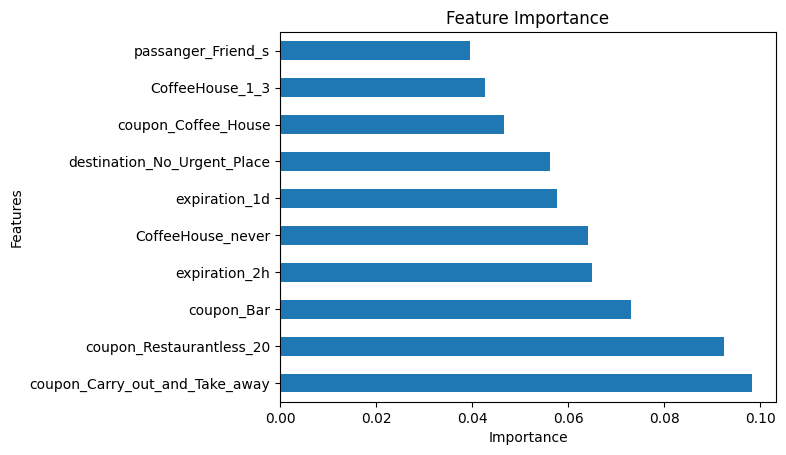

In [61]:
# Plot feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Conclusión

El modelo seleccionado corresponde al Random Forest, el cual arroja en el conjunto de Validación una tasa de error:  *0.320021*, si bien los modelos XGboost y GBM tienen tasas de error menores en el conjunto de validación, durante su entrenamiento estos modelos realizan un overfitting de los datos, es por ello que no se utilizará para el modelo final que pasará a producción.

Los hiperparámetros para modelar serán:
* 'max_leaf_nodes': 30
* 'min_samples_leaf': 100
* 'n_estimators': 500

La semilla que permitirá obtener resultados comparables es:
* Seed: 12345

## Tasas de error
A continuación se muestran las tasas de error que han sido utilizadas para tomar la decisión
**Random Forest**
* Entrenamiento - tasa de error: 0.2951
* Validación - tasa de error: 0.3200

XGBoost
* Entrenamiento - tasa de error: 0.0071
* Validación - tasa de error: 0.2588

Gradient Boosting Machine
* Entrenamiento - tasa de error 0.0342
* Validación - tasa de error: 0.2588

Treebag
* Entrenamiento - tasa de error: 0.3058
* Validación - tasa de error: 0.3295

Benchmark - Logístico
* Entrenamiento - tasa de error: 0.3013
* Validación - tasa de error: 0.3213